# Adaptive Stress Testing: Walk1D Example

This notebook expands on the Walk1D example, see the Walk1D.jl file for interface implementation details.

In [ ]:
using Revise
include("../test/Walk1D.jl");

### Setup/create AST planner
* `planner` is used to play out the policy
* `planner.mdp::ASTMDP` is the main MDP problem formulation object for AST (this holds reward metrics)
* `planner.mdp.sim::Walk1DSim` is the main simulation object, holding all simulation information (e.g., current x position, settings for the simulation, etc)

In [5]:
planner = setup_ast();

### Run AST with Monte Carlo Tree Search (MCTS)

In [6]:
tree = search!(planner; return_tree=true);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


State = 0x23048a698079999e	:	Q = -24.267449511464495	:	Action = 0x109da377
State = 0xb0c858489fe61de1	:	Q = -20.44956622526974	:	Action = 0xc1cb6abd
State = 0x679fb216eb9b391c	:	Q = -15.189107879432822	:	Action = 0x9a6c89a9
State = 0xaf0d0c5abd5fce6b	:	Q = -13.260579731472928	:	Action = 0xedc1929d
State = 0x2e53980652523afd	:	Q = -11.05609218088567	:	Action = 0xa0d4d105
State = 0x1619ae4b1ad42d3e	:	Q = -8.48410634985635	:	Action = 0x30b59a9
State = 0x7c5bae8655a76cd8	:	Q = -6.287600544402934	:	Action = 0xef133c9b
State = 0x9e851d5e84878671	:	Q = -3.2182088903844117	:	Action = 0xcfabd102
State = 0x16e0dd0115d1fe3e	:	Event.


### Visualize interactive MCTS tree (using D3.js)

In [7]:
d3tree = visualize(tree)

0x23048a698079999e
N:   1000

├──             [0xf01bca90]
│  Q: -50.46
│  N:      2

│  └──       0xf6a8b19ec7b074a8
│     N:      1

│     └──             [0x7de00dc2]
│        Q: -54.17
│        N:      1
 (1 children)
├──             [0xb9832f51]
│  Q: -49.87
│  N:      6

│  └──       0x877103639f62fecf
│     N:      5

│     ├──             [0x23e558d7]
│     │  Q: -48.40
│     │  N:      2
 (1 children)
│     ├──             [0x525f7fd6]
│     │  Q: -47.35
│     │  N:      2
 (1 children)
│     └──             [0x54536f09]
│        Q: -58.81
│        N:      1
 (1 children)
├──             [0x109da377]
│  Q: -24.27
│  N:    943

│  └──       0xb0c858489fe61de1
│     N:    942

│     ├──             [0x28ec022e]
│     │  Q: -44.78
│     │  N:     20
 (1 children)
│     ├──             [0x55662a1e]
│     │  Q: -53.38
│     │  N:      1
 (1 children)
│     ├──             [0xfe1cfe99]
│     │  Q: -47.63
│     │  N:      2
 (1 children)
│     ├──             [0x7fa47723]
│     │  Q: -50.36
│     │  N:      1
 (1 children)
│     ├──             [0x22f14d3d]
│     │  Q: -50.23
│     │  N:      1
 (1 children)
│     ├──             [0xc1cb6abd]
│     │  Q: -20.45
│     │  N:    889
 (1 children)
│     ├──             [0xb1a96deb]
│     │  Q: -43.54
│     │  N:      1
 (1 children)
│     ├──             [0xa3b3a5a9]
│     │  Q: -42.07
│     │  N:      1
 (1 children)
│     ├──             [0xf0f2cea9]
│     │  Q: -44.64
│     │  N:      1
 (1 children)
│     ├──             [0x30534064]
│     │  Q: -58.06
│     │  N:      1
 (1 children)
│     ├──             [0xd254a6db]
│     │  Q: -48.13
│     │  N:      1
 (1 children)
│     ├──             [0x40249ce9]
│     │  Q: -36.90
│     │  N:      3
 (1 children)
│     ├──              [0x99ae014]
│     │  Q: -35.93
│     │  N:      2
 (1 children)
│     ├──             [0xdf4198ba]
│     │  Q: -59.15
│     │  N:      1
 (1 children)
│     ├──             [0x25542b96]
│     │  Q: -38.83
│     │  N:      1
 (1 children)
│     ├──             [0x8850e118]
│     │  Q: -44.59
│     │  N:      1
 (1 children)
│     ├──             [0x4c2f97d9]
│     │  Q: -48.60
│     │  N:      1
 (1 children)
│     ├──             [0x713e6e51]
│     │  Q: -45.14
│     │  N:      1
 (1 children)
│     ├──             [0x95bd291a]
│     │  Q: -49.36
│     │  N:      1
 (1 children)
│     ├──             [0x40fb1b7a]
│     │  Q: -43.15
│     │  N:      1
 (1 children)
│     ├──             [0xd462b6eb]
│     │  Q: -48.07
│     │  N:      1
 (1 children)
│     ├──             [0x602b7fe0]
│     │  Q: -48.56
│     │  N:      1
 (1 children)
│     ├──             [0x8761ce25]
│     │  Q: -42.74
│     │  N:      1
 (1 children)
│     ├──             [0xa7c66026]
│     │  Q: -43.93
│     │  N:      1
 (1 children)
│     ├──             [0xa2c64356]
│     │  Q: -57.00
│     │  N:      1
 (1 children)
│     ├──             [0x31920309]
│     │  Q: -33.18
│     │  N:      1
 (1 children)
│     ├──             [0xa28da080]
│     │  Q: -45.81
│     │  N:      1
 (1 children)
│     ├──             [0x8f64c523]
│     │  Q: -44.23
│     │  N:      1
 (1 children)
│     ├──             [0xc39293a7]
│     │  Q: -50.96
│     │  N:      1
 (1 children)
│     ├──             [0xe61241ab]
│     │  Q: -41.40
│     │  N:      1
 (1 children)
│     └──             [0xa1c9e4eb]
│        Q: -47.40
│        N:      1
 (1 children)
├──             [0x48f73c76]
│  Q: -48.65
│  N:     10

│  └──        0x291711d86134024
│     N:      9

│     ├──             [0xa59b8474]
│     │  Q: -48.07
│     │  N:      6
 (1 children)
│     ├──             [0xe2af3b5b]
│     │  Q: -49.64
│     │  N:      1
 (1 children)
│     └──             [0x5270b05f]
│        Q: -48.07
│        N:      2
 (1 children)
├──             [0x82547fe2]
│  Q: -50.13
│  N:      4

│  └──       0x16cf612d4d71b68a
│     N:      3

│     ├──             [0xe6be82fe]
│     │  Q: -52.16
│     │  N:      2
 (1 children)
│     └──             [0x2250e19d]
│        Q: -46.1

# Plots/Figures

### Episodic metric plots
Plots the episodic metrics, including running miss distance mean, minimum miss distance, and cumulative failures all over episode (i.e. iteration)

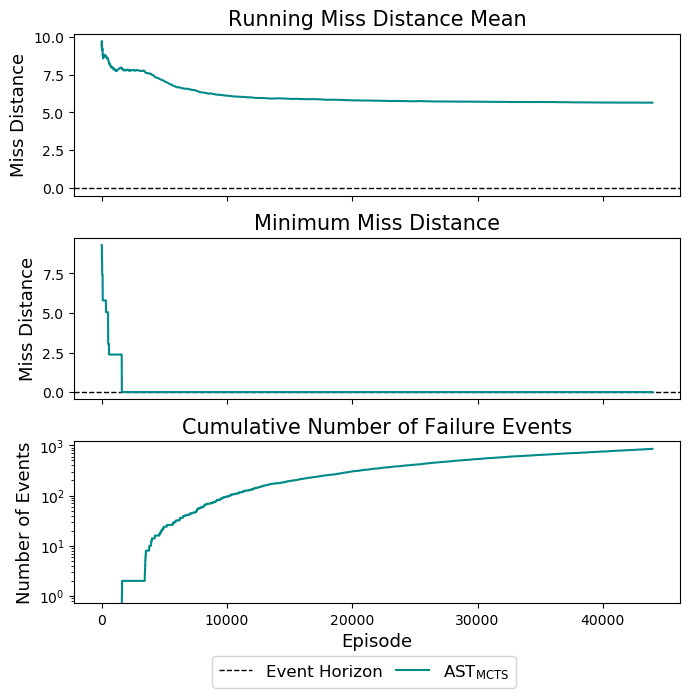

First failure: 1594 of 43971
Number of failures: 853
Failure rate: 1.93991%


1.9399149439403245

In [15]:
episodic_figures(planner.mdp.metrics; gui=false)

### Distribution plots
Plots miss distance distribution and log-likelihood distribution.

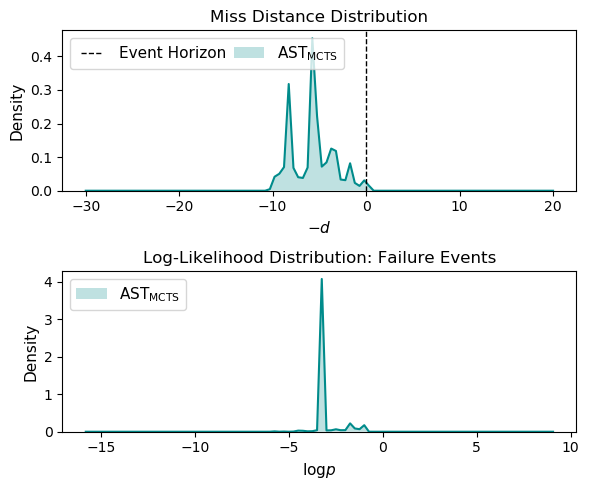

In [14]:
distribution_figures(planner.mdp.metrics; gui=false)

# Metrics
Print failure event metrics.

In [16]:
failure_rate = print_metrics(planner)

First failure: 1594 of 43971
Number of failures: 853
Failure rate: 1.93991%


1.9399149439403245

# CEM Solver
First, we run the search again with the cross-entropy method solver `CEMSolver`.

In [18]:
planner = setup_ast(solver=CEMSolver)
action_trace = search!(planner);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:12


In [19]:
failure_rate = print_metrics(planner)

First failure: 265 of 715938
Number of failures: 99773
Failure rate: 13.93598%


13.935983283468682

# Playback

Functions to playback the policy, and look at failure trajectories.

In [20]:
final_state= playback(planner, action_trace, sim->sim.x)

0.0
-1.4681565073056968
-2.8790682106764236
-4.5318598317096015
-6.002385457333659
-7.38293658747257
-8.641661367101024
-10.000020551648118


ASTState
  t_index: Int64 8
  parent: ASTState
  action: ASTSampleAction
  hash: UInt64 0xa089c23f12a50a77
  q_value: Float64 -1.841508370326395
  terminal: Bool true
